# Bert Sentiment Analysis and Hybrid Collaborative Filtering on Goodreads Dataset

This project seeks to use the Goodreads review dataset to do BERT sentiment analysis and hybrid collaborative filtering. For more details, see the project report pdf.

### Imports and Setup

Here we import the required packages.

In [1]:
import os
import psutil
import time
import requests
import gzip
import json
import gc

import tensorflow as tf
import keras
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np

from transformers import AutoTokenizer, TFDistilBertForSequenceClassification, TFAutoModelForSequenceClassification
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix, coo_matrix, hstack

from FetchTitle import fetch_title

tf.get_logger().setLevel('ERROR')

2024-12-04 21:16:26.355364: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-04 21:16:26.920471: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 21:16:26.927688: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-04 21:16:26.927703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

Some of the BERT sentiment analysis was tested on a personal GPU. The following cells check for the GPU and then sets its memory growth.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) # Set GPU memory growth, if exists
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


We read in the goodreads reviews dataset for spoiler detection (raw). The `printmem` function prints the current memory usage. 

In [2]:
def printmem():
    process = psutil.Process(os.getpid())
    print(round(process.memory_info().rss/(10**9),3), 'Gbytes')  # in bytes 

In [3]:
print("Start of process, memory used:")
printmem()

# Read in the json.gz dataset
df_full = pd.read_json('goodreads_reviews_spoiler_raw.json.gz', 
                  lines=True)
print("Memory after dataframe read in:")
printmem()
print("Size of dataframe:", len(df_full))

Start of process, memory used:
0.792 Gbytes
Memory after dataframe read in:
7.176 Gbytes
Size of dataframe: 1378033


### Inspecting the Data

We first look at all the columns in the dataset and then look at the head of the dataframe to see what is included. 

In [4]:
df_full.columns

Index(['user_id', 'book_id', 'review_id', 'rating', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')

In [5]:
print(df_full.head(5))

                            user_id   book_id  \
0  8842281e1d1347389f2ab93d60773d4d  18245960   
1  8842281e1d1347389f2ab93d60773d4d     16981   
2  8842281e1d1347389f2ab93d60773d4d  28684704   
3  8842281e1d1347389f2ab93d60773d4d  27161156   
4  8842281e1d1347389f2ab93d60773d4d  25884323   

                          review_id  rating  \
0  dfdbb7b0eb5a7e4c26d59a937e2e5feb       5   
1  a5d2c3628987712d0e05c4f90798eb67       3   
2  2ede853b14dc4583f96cf5d120af636f       3   
3  ced5675e55cd9d38a524743f5c40996e       0   
4  332732725863131279a8e345b63ac33e       4   

                                         review_text  \
0  This is a special book. It started slow for ab...   
1  Recommended by Don Katz. Avail for free in Dec...   
2  A fun, fast paced science fiction thriller. I ...   
3  Recommended reading to understand what is goin...   
4  I really enjoyed this book, and there is a lot...   

                       date_added                    date_updated  \
0  Sun Jul 30 07

We can see from this head that some of the review ratings are zero. We inspect that to see what that could correspond to.

In [6]:
df_full[df_full['rating']==0].head(5) # Head of dataframe for rating values of 0

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
3,8842281e1d1347389f2ab93d60773d4d,27161156,ced5675e55cd9d38a524743f5c40996e,0,Recommended reading to understand what is goin...,Wed Nov 09 17:37:04 -0800 2016,Wed Nov 09 17:38:20 -0800 2016,,,5,1
7,8842281e1d1347389f2ab93d60773d4d,24189224,dbc01e2438df7a87ee3dc16ee23a53e5,0,Numerous people in publishing have told me thi...,Fri May 29 17:48:57 -0700 2015,Fri May 29 17:49:40 -0700 2015,,,11,5
13,8842281e1d1347389f2ab93d60773d4d,16158596,6ff8bbc4856aa403bbd8990407c9c77a,0,Recommended by David Risher,Mon Jul 07 10:56:15 -0700 2014,Mon Jul 07 10:56:39 -0700 2014,,,0,0
54,8842281e1d1347389f2ab93d60773d4d,151,daab5f2752243787e471e2ac01bf12fc,0,"Well if Melanie says its her BBE, I gotta chec...",Mon May 14 12:55:56 -0700 2007,Sat Jan 07 11:40:38 -0800 2017,,,1,2
58,8842281e1d1347389f2ab93d60773d4d,259028,fb4acc8a30bac6bf1414a03303d43c26,0,"If steve recommends it, it must be good!",Thu Jan 18 11:09:48 -0800 2007,Mon Mar 09 00:38:30 -0700 2015,,,2,2


It seems that these reviews are people who were recommended to read a book, but with verbage like "it must be good!", it seems that these reviews are from users who actually haven't or haven't completed reading the book in question. Therefore, we elect to drop these rows.

In [7]:
df_full = df_full.drop(df_full[df_full['rating']==0].index) # Drop rows with rating value of 0
print(len(df_full))

1330981


We also check if there are any null values in the dataframe. It seems there are none, so we can proceed as normal.

In [8]:
df_full.isna().sum() 

user_id         0
book_id         0
review_id       0
rating          0
review_text     0
date_added      0
date_updated    0
read_at         0
started_at      0
n_votes         0
n_comments      0
dtype: int64

We now inspect the distribution of ratings. We see that distribution of reviews is skewed towards higher ratings, which could make sense as Goodreads reviews likely love reading, and therefore are more likely to enjoy a book that they are reading, thus leaving higher-rated reviews.

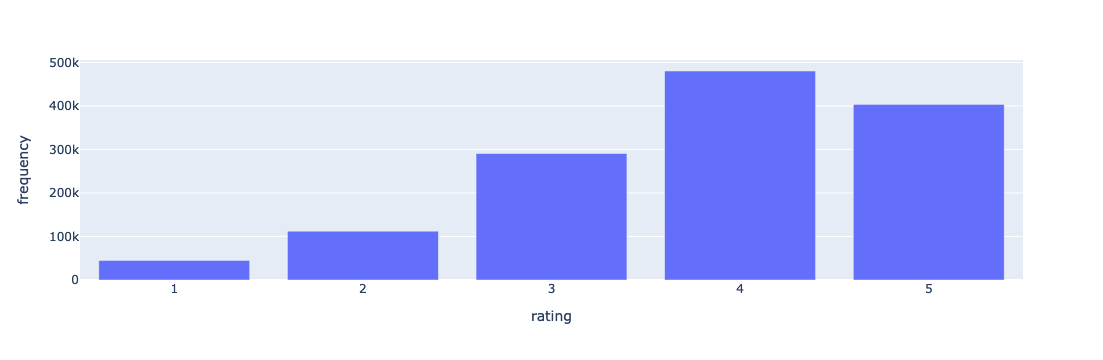

In [9]:
# Group the dataframe by rating and count the frequency of each rating 
grouped_df = df_full.groupby('rating').size().reset_index(name='frequency')

# Plot the bar graph of the grouped dataframe
fig = px.bar(grouped_df, x='rating', y='frequency')
fig.show('plotly_mimetype')

Next, we process the review data itself for BERT. We make all the characters lowercase, strip any excess whitespace, and remove any new-line or tab characters, to allow for the better sentiment analysis.

In [10]:
df_full['review_text'] = df_full['review_text'].str.lower().str.strip().str.replace(r'[\n\t]', ' ')
df_full.head(1)

,user_id,book_id,review_id,rating,review_text,date_added,date_updated,read_at,started_at,n_votes,n_comments
0,8842281e1d1347389f2ab93d60773d4d,18245960,dfdbb7b0eb5a7e4c26d59a937e2e5feb,5,this is a special book. it started slow for ab...,Sun Jul 30 07:44:10 -0700 2017,Wed Aug 30 00:00:26 -0700 2017,Sat Aug 26 12:05:52 -0700 2017,Tue Aug 15 13:23:18 -0700 2017,28,1


We check for pure duplicate rows, but we fine none, which is good!

In [11]:
duplicates = df_full[df_full.duplicated()]
print(duplicates)

Empty DataFrame
Columns: [user_id, book_id, review_id, rating, review_text, date_added, date_updated, read_at, started_at, n_votes, n_comments]
Index: []


However, pure duplicate rows aren't the only duplicates we're concerned about. We drop any rows that have the *exact* same review text. It would not make sense for the same user or other users to have multiple reviews with duplicate review texts, so we drop those for safety.

In [12]:
print(len(df_full))
df_full = df_full.drop_duplicates(subset='review_text')
print(len(df_full))

1330981
1315663


Now we make the same bar graph we did earlier, but we do so for a 10% subset of the original dataframe. As seen in the previous cell, the length of the dataframe is over 1.3 million, so a 10% subset would be around 130,000 rows. We do this because training BERT on 1.3 million values would be extremely computationally expensive, so the subset helps to save resources. We use the pandas sample method which helps ensure that the data sampled is stratified (relative frequency is close to that of the original dataframe).

131567


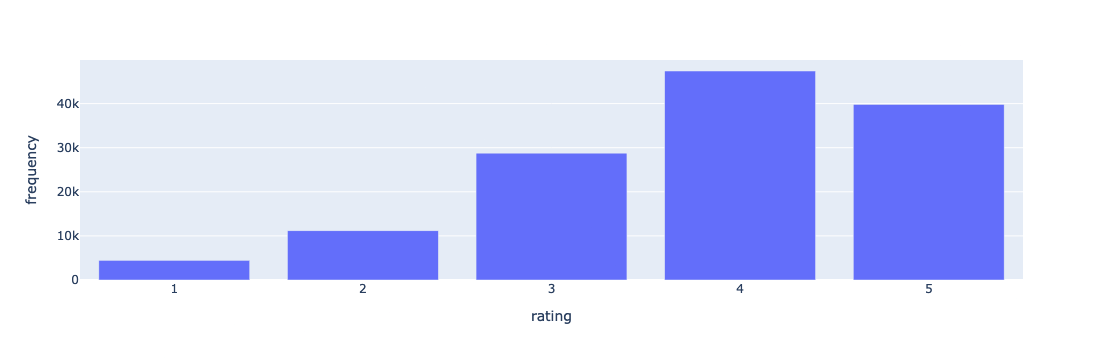

In [13]:
# Stratify sample 10% of the original dataframe 
df = df_full.groupby(['rating']).sample(frac=0.1, random_state=42)
print(len(df))

# Make a grouped dataframe by rating counting frequency of rating and then making a bar graph of it
grouped_df_2 = df.groupby(['rating']).size().reset_index(name='frequency')
fig = px.bar(grouped_df_2, x='rating', y='frequency')
fig.show('plotly_mimetype')

We can ensure that the data was stratified properly by making a side-by-side bar graph of the relative frequency of the rating in the original and subset dataframes. We see that the relative frequencies match closely.

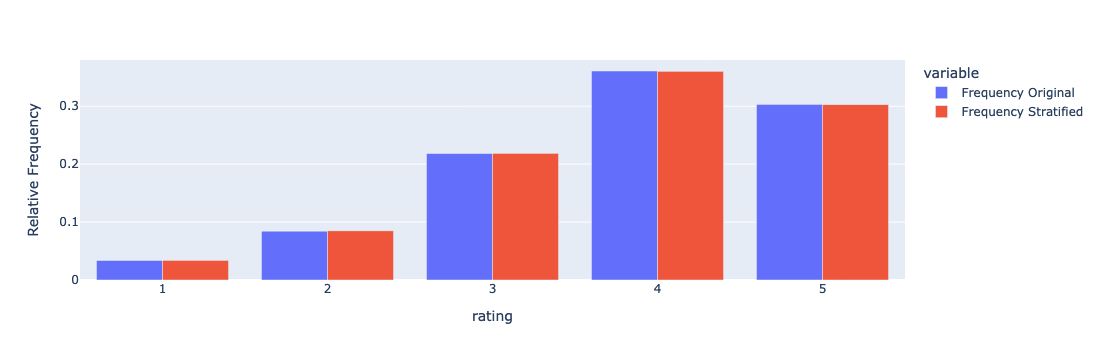

In [14]:
# Get relative frequencies based on total amount of rows
grouped_df['frequency'] = grouped_df['frequency'] / grouped_df['frequency'].sum()
grouped_df_2['frequency'] = grouped_df_2['frequency'] / grouped_df_2['frequency'].sum()

# Merge the dataframes into one dataframe based on rating
df_combined = pd.merge(grouped_df, grouped_df_2, on='rating')

# Make the side-by-side bar chart
fig = px.bar(df_combined, x='rating', y=['frequency_x', 'frequency_y'], barmode='group',
             labels={'value': 'Relative Frequency'})

# Change the labels of the variables
fig.data[0].name = "Frequency Original"
fig.data[0].hovertemplate = "Frequency Original: %{y}"
fig.data[1].name = "Frequency Stratified"
fig.data[1].hovertemplate = "Frequency Stratified: %{y}"
    
fig.show('plotly_mimetype')

#fig.write_image('stratified.png')

Now we make the train and test sets. We use `GroupShuffleSplit` instead of scikit-learn's `train_test_split`, because we want books with the same ID to *not* be split across the train and test set, hoping that the BERT model will be able to better learn sentiment analysis if all of the same book are in one part of the set. 

In [15]:
group_kfold = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Iterate the GroupShuffleSplit for 1 split, grouping the dataframe and its ratings based on book ID, as described earlier
train_set, test_set = None, None
for train_index, test_index in group_kfold.split(df, df['rating'], groups=df['book_id']):
    train_set = df.iloc[train_index]
    test_set = df.iloc[test_index]

print(len(train_set))
print(len(test_set))

105253
26314


We then drop all the unnecessary columns for sentiment analysis. We just keep the rating and the review text. We do this after group splitting, since we are dropping the book id, as it is not needed by BERT.

In [16]:
train_set = train_set.drop(['user_id', 'book_id', 'review_id', 'date_added', 'date_updated',
                            'read_at', 'started_at', 'n_votes', 'n_comments'], axis=1)
test_set = test_set.drop(['user_id', 'book_id', 'review_id', 'date_added', 'date_updated',
                            'read_at', 'started_at', 'n_votes', 'n_comments'], axis=1)

We then use `train_test_split` to make a validation set. It is fine that we don't use `GroupShuffleSplit` again, since all of these data points will be used only in training/validation per epoch. We take a 20% validation size of the 80% full training size. 

In [17]:
X_train = train_set['review_text'].tolist()
y_train = train_set['rating'].tolist()
X_test = test_set['review_text'].tolist()
y_test = test_set['rating'].tolist()

# Make a validation set out of the full 80% train set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### BERT-Tiny Sentiment Analysis

BERT is an extremely large and computationally expensive model with millions of trainable parameters. To save training time and resources, we use the smallest of the BERT models, BERT-Tiny. We fetch the tokenizer required for BERT-Tiny.

In [20]:
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

C:\Users\nghug\anaconda3\envs\fp2\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



We then use the tokenizer to tokenize the train, test, and validation sets, truncated and padding when needed, using a max length of 200.

In [21]:
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=200)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=200)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=200)

Then we fetch the pre-trained model for BERT-Tiny. We require 6 labels instead of 5, since our rating values are not one-hot encoded and range from 1-5, not 0-4. We compile it using a 1e-5 learning rate Adam optimizer and we use sparse categorical crossentropy as our minimizing loss function. We track the accuracy.

In [25]:
# Fetch the model
model = TFAutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=6, from_pt=True)

# Compile it
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

C:\Users\nghug\anaconda3\envs\fp2\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

C:\Users\nghug\anaconda3\envs\fp2\lib\site-packages\transformers\modeling_tf_pytorch_utils.py:129: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user

These tokenized sets cannot themselves be passed into the model. We have to using Tensoflow's `from_tensor_slices` function to be able to train on the data. The slices contain a dictionary of the train encodings, and their respective rating values in `y_train` for example. 

In [26]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

We now train the model. We shuffle an train in batches of 16 for 30 epochs. We introduce two training callbacks: `EarlyStopping` monitoring validation loss with a patience of 3 epochs, and a `ModelCheckpoint` saving the best model per epoch based on val loss, saving only the best model and only its weights.

In [27]:
callbacks = [EarlyStopping(monitor='val_loss', patience=3),
             ModelCheckpoint(filepath='best_model', monitor='val_loss', save_best_only=True, save_weights_only=True)]
history = model.fit(train_dataset.shuffle(1000).batch(16), epochs=30, batch_size=16,
          validation_data=val_dataset.shuffle(1000).batch(16), callbacks=callbacks)

Epoch 1/30
5263/5263 [==============================] - 143s 27ms/step - loss: 2.1290 - accuracy: 0.3480 - val_loss: 1.4231 - val_accuracy: 0.3804
Epoch 2/30
5263/5263 [==============================] - 135s 26ms/step - loss: 1.4066 - accuracy: 0.3795 - val_loss: 1.3108 - val_accuracy: 0.4280
Epoch 3/30
5263/5263 [==============================] - 135s 26ms/step - loss: 1.3097 - accuracy: 0.4378 - val_loss: 1.2679 - val_accuracy: 0.4463
Epoch 4/30
5263/5263 [==============================] - 139s 26ms/step - loss: 1.2518 - accuracy: 0.4667 - val_loss: 1.2054 - val_accuracy: 0.4738
Epoch 5/30
5263/5263 [==============================] - 136s 26ms/step - loss: 1.2095 - accuracy: 0.4870 - val_loss: 1.1743 - val_accuracy: 0.4956
Epoch 6/30
5263/5263 [==============================] - 136s 26ms/step - loss: 1.1669 - accuracy: 0.4970 - val_loss: 1.1411 - val_accuracy: 0.5059
Epoch 7/30
5263/5263 [==============================] - 138s 26ms/step - loss: 1.1416 - accuracy: 0.5094 - val_loss: 1

Now, let's examing the results of the training. We create a dataframe of the training and validation accuracy per epoch. We see that both accuracies were increasing per epoch, but starting decreasing. It's possible that the accuracy would have increased further, but to save computational resources, we believe this result is sufficient, as a roughly 55% accuracy is much better than random guessing (20%). 

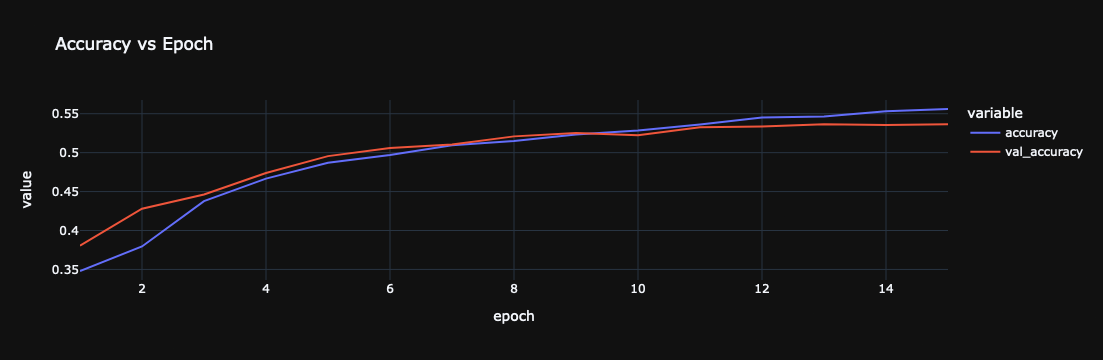

In [28]:
# Make a dataframe of the training history
dfr = pd.DataFrame(history.history)

# Fix the epoch index
dfr['epoch'] = dfr.index + 1

# Make a line plot of accuracy and val accuracy per epoch
fig = px.line(dfr, x='epoch', y=['accuracy', 'val_accuracy'], title='Accuracy vs Epoch')
fig.show('plotly_mimetype')
fig.write_image('accuracy.png')

We do the same as above for loss, and we see a good decreasing loss per epoch.

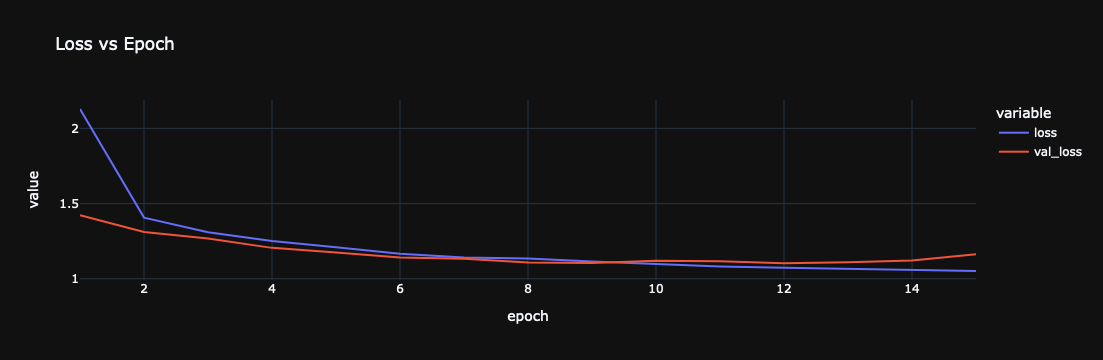

In [29]:
fig = px.line(dfr, x='epoch', y=['loss','val_loss'], title='Loss vs Epoch')
fig.show('plotly_mimetype')
fig.write_image('loss.png')

We now evaluate the best model on the test set. Since we only saved the best model's weights, we need to recompile a pretrained model and then load the weights.

In [32]:
# Fetch the model and compile it, like earlier
best_model = TFAutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=6, from_pt=True)
best_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Load the best model weights
best_model.load_weights('best_model')

# Evaluate the test dataset
evals = best_model.evaluate(test_dataset.batch(16))

C:\Users\nghug\anaconda3\envs\fp2\lib\site-packages\huggingface_hub\file_download.py:797: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.

C:\Users\nghug\anaconda3\envs\fp2\lib\site-packages\transformers\modeling_tf_pytorch_utils.py:129: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user

1645/1645 [==============================] - 33s 18ms/step - loss: 1.0831 - accuracy: 0.5310


We retain a good validation accuracy of 53%, close to the training accuracy. Since the book id's were group shuffled, the trained model has not done any sentiment analysis on any of these books nor their respective reviews. This close accuracy indicates we did a good job at making a generalized model. We know look at the confusion matrix of the dataset to see how the model performed more closely.

1645/1645 [==============================] - 15s 9ms/step


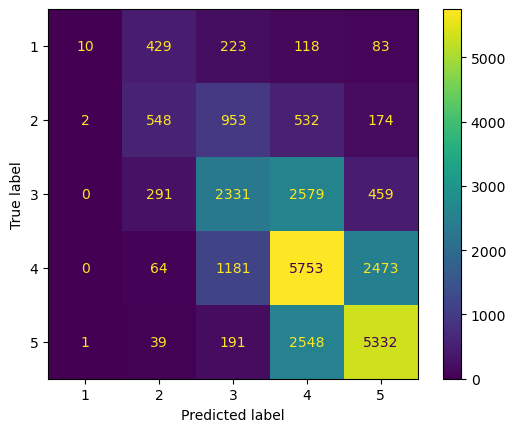

In [37]:
from sklearn import metrics

y_pred = best_model.predict(test_dataset.batch(16)) # Predict the rating values on the test dataset
y_pred = tf.nn.softmax(y_pred.logits) # Apply softmax to the logits of the prediction
y_pred = tf.argmax(y_pred, axis=1) # Take the argument maximum, which leads to the predicted rating

# Create a confusion matrix of the true test ratings and the predicted ones
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)

# Displays the confusion matrix nicely
confusion_matrix_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[1, 2, 3, 4, 5])

confusion_matrix_display.plot()
plt.savefig('confusion_matrix.png')
plt.show()

From this, we can see that the predicted label seems to "float" around the true label, meaning that the model rarely predicts an opposite sentiment. We can see that only one 5 rating was predicted as a 1 rating, and only 83 1 ratings were predicted as 5 ratings. 

### Hybrid Collaborative Filtering

We now move on to hybrid collaborative filtering. We inspect the original full dataframe once again.

In [15]:
print(df_full.head(5))

                            user_id   book_id  \
0  8842281e1d1347389f2ab93d60773d4d  18245960   
1  8842281e1d1347389f2ab93d60773d4d     16981   
2  8842281e1d1347389f2ab93d60773d4d  28684704   
4  8842281e1d1347389f2ab93d60773d4d  25884323   
5  8842281e1d1347389f2ab93d60773d4d  19398490   

                          review_id  rating  \
0  dfdbb7b0eb5a7e4c26d59a937e2e5feb       5   
1  a5d2c3628987712d0e05c4f90798eb67       3   
2  2ede853b14dc4583f96cf5d120af636f       3   
4  332732725863131279a8e345b63ac33e       4   
5  ea4a220b10e6b5c796dae0e3b970aff1       4   

                                         review_text  \
0  this is a special book. it started slow for ab...   
1  recommended by don katz. avail for free in dec...   
2  a fun, fast paced science fiction thriller. i ...   
4  i really enjoyed this book, and there is a lot...   
5  a beautiful story. it is rare to encounter a b...   

                       date_added                    date_updated  \
0  Sun Jul 30 07

For collaborative filtering, we only care about the user ids, the book ids, and the rating values. We drop all other frames and save that to a new dataframe instance. This gives us 18,865 unique users over 25,469 unique books.

In [16]:
df_cf = df_full.drop(['review_id', 'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes', 'n_comments', 'review_text'], axis=1)
print(df_cf.head(5))

                            user_id   book_id  rating
0  8842281e1d1347389f2ab93d60773d4d  18245960       5
1  8842281e1d1347389f2ab93d60773d4d     16981       3
2  8842281e1d1347389f2ab93d60773d4d  28684704       3
4  8842281e1d1347389f2ab93d60773d4d  25884323       4
5  8842281e1d1347389f2ab93d60773d4d  19398490       4


In [17]:
print(len(df_cf.user_id.unique()))
print(len(df_cf.book_id.unique()))

18865
25469


We now pivot the dataframe to make a matrix-like object, where one axis has the user id value, the other has the book id value, and the values inside are the rating values from the dataframe. We fill values of 0 where the user has not rating a book in the matrix. We then use Scipy to make a CSR matrix of the matrix, which is a structure used to efficiently represent sparse matrices (matrices where most values are 0). 

In [139]:
# Make the matrix using a dataframe pivot
matx = df_cf.pivot(index='user_id', columns='book_id', values='rating').fillna(0)

# Make the sparse matrix (CSR matrix)
matx_sparse = csr_matrix(matx)

Even though most of the values are 0, we still have a lot of filled values. We can loosely visualize this by making a scatter of all the different ratings contained in the matrix. On one axis we have the user id (as an index, not the true id), and likewise for book ids on the other axis.

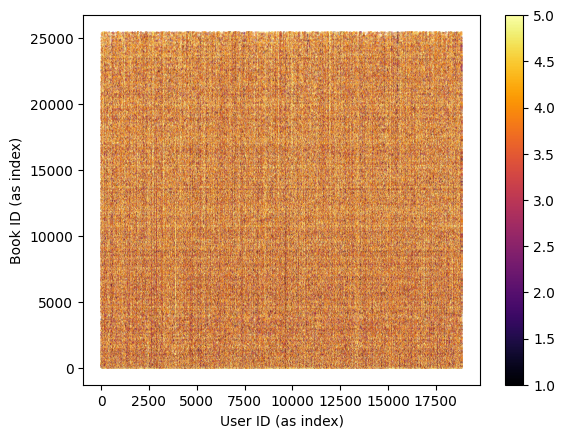

In [140]:
# Make a dictionary of the matrix and extract the keys and values
mx_dict = matx_sparse.todok()
xy = np.array(list(mx_dict.keys()))
vals = np.array(list(mx_dict.values()))

# We scatter the non-zero values of the matrix
plt.scatter(xy[:,0], xy[:,1], s=0.01, c=vals, cmap='inferno')
plt.colorbar()
plt.xlabel('User ID (as index)')
plt.ylabel('Book ID (as index)')
#plt.savefig('matrix.png')
plt.show()

In [142]:
original_column_names = matx.columns.get_level_values(0)
print(original_column_names)

Index([       1,        2,        3,        5,        6,       11,       33,
             34,       59,      104,
       ...
       36103768, 36107506, 36114743, 36123887, 36135327, 36158863, 36196052,
       36242916, 36252773, 36328685],
      dtype='int64', name='book_id', length=25469)


In [143]:
original_column_names.tolist()[130]

3526

For the first part of collaborative filtering, we use KNN, or K-Nearest-Neighbors. We use a brute method, meaning that the distances between all points are calculated. Nearest neighbors by our definition uses cosine similarity to find 10 nearest neighbors to a point in the vectors space. We fit it to the sparse matrix.

In [144]:
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
knn.fit(matx_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

Now we create two functions. One that prints the recommendations for a user based on some given values. The other predicts ratings using KNN for a user, with a given number of recommendations to find.

In [149]:
def print_recs(vals, user_id):
    # Print the recommendations for a user (values given)
    print(f'Top {len(vals)} Recommendations for {user_id}')
    for _, data in enumerate(vals):
        print(f'ID: {data[0]}, Pred Score: {data[1]}')

def predict_rating(user_id, n_recs=5):
    # Find the distances and indices of the nearest neighbors by locating the user ratings in the matrix
    distances, indices = knn.kneighbors(matx.loc[user_id, :].values.reshape(1, -1), n_neighbors=10)

    similar_users = indices.flatten() # get the similar users from KNN using the indices
    scores = {}
    num_rated = {}

    # Iterate the similar users
    for i in similar_users:
        n = matx.iloc[i].name
        if n == user_id: # Don't use user's own ratings as ratings/recommendations
            continue
        # Iterate the closest values for the similar users, and add the predicted scores
        for j in matx.columns:
            if matx.loc[user_id, j] == 0:
                scores[j] = scores.get(j, 0) + matx.loc[n, j]
                num_rated[j] = num_rated.get(j, 0) + 1

    # Weight the scores based on the amount of times input was given to the score
    for _ in num_rated.keys():
        scores[_] /= num_rated[_]

    # Return recommendations
    if n_recs is not None:
        recs = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n_recs]
    else:
        recs = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:]
    return recs

pred = predict_rating('000883382802f2d95a3dd545bb953882')
print_recs(pred, '000883382802f2d95a3dd545bb953882')

Top 5 Recommendations for 000883382802f2d95a3dd545bb953882
ID: 11870085, Pred Score: 3.888888888888889
ID: 8591107, Pred Score: 3.111111111111111
ID: 6339664, Pred Score: 2.888888888888889
ID: 7791997, Pred Score: 2.7777777777777777
ID: 3777732, Pred Score: 2.6666666666666665


We can see how this works for a few more users:

In [151]:
pred = predict_rating('01ec1a320ffded6b2dd47833f2c8e4fb')
print_recs(pred, '01ec1a320ffded6b2dd47833f2c8e4fb')
pred = predict_rating('83d6e6f80d7c32c6676b3ab3b01543cd')
print_recs(pred, '83d6e6f80d7c32c6676b3ab3b01543cd')

Top 5 Recommendations for 01ec1a320ffded6b2dd47833f2c8e4fb
ID: 17831614, Pred Score: 3.7777777777777777
ID: 25573737, Pred Score: 3.6666666666666665
ID: 33133783, Pred Score: 3.6666666666666665
ID: 16070903, Pred Score: 3.5555555555555554
ID: 27844420, Pred Score: 3.5555555555555554
Top 5 Recommendations for 83d6e6f80d7c32c6676b3ab3b01543cd
ID: 16081272, Pred Score: 2.2222222222222223
ID: 17333880, Pred Score: 1.8888888888888888
ID: 13184992, Pred Score: 1.6666666666666667
ID: 15784909, Pred Score: 1.6666666666666667
ID: 16113791, Pred Score: 1.6666666666666667


Now, we use SVD as a part of collaborative filtering. Like above, we define a function that can predict ratings based on a user id and the number of recommendations to give.

In [152]:
# Use scikit-learn Truncated SVD. We find 100 components
svd = TruncatedSVD(n_components=100, random_state=42)

# Fit the sparse matrix and get the component factors
user_factors = svd.fit_transform(matx_sparse)
item_factors = svd.components_

def predict_rating_svd(user_id, n_recs=5):
    # Predict ratings using SVD

    # This inner rating function uses a dot product to get a rating value for a book from the component factors from above
    def inner_rating(user_id, book_id):
        user_index = matx.index.get_loc(user_id)
        item_index = matx.columns.get_loc(book_id)
    
        predicted_rating = np.dot(user_factors[user_index], item_factors[:, item_index].T) # dot product
        return predicted_rating

    # Get predicted ratings for every zero-rating in the user's row (meaning that they have not already rated the book in question)
    ratings = {}
    for _ in matx.columns:
        if matx.loc[user_id][_] > 0.0:  # don't rate books already rated by the user
            continue
        predicted_rating = inner_rating(user_id, _)
        ratings[_] = predicted_rating

    # Return the recommendations
    if n_recs is not None:
        recs = sorted(ratings.items(), key=lambda x: x[1], reverse=True)[:n_recs]
    else:
        recs = sorted(ratings.items(), key=lambda x: x[1], reverse=True)
    return recs
        
user_ids = ['000883382802f2d95a3dd545bb953882', '01ec1a320ffded6b2dd47833f2c8e4fb', '83d6e6f80d7c32c6676b3ab3b01543cd']
for _ in user_ids:
    print_recs(predict_rating_svd(_), _)

Top 5 Recommendations for 000883382802f2d95a3dd545bb953882
ID: 6339664, Pred Score: 2.3444766540596462
ID: 3777732, Pred Score: 2.274470712610798
ID: 15717943, Pred Score: 2.267085194156738
ID: 13372690, Pred Score: 2.113577420449349
ID: 8755785, Pred Score: 2.022502610454564
Top 5 Recommendations for 01ec1a320ffded6b2dd47833f2c8e4fb
ID: 13612739, Pred Score: 4.028775139992119
ID: 12513614, Pred Score: 3.7663830863906833
ID: 16150996, Pred Score: 3.6395760847067087
ID: 23355069, Pred Score: 3.5215054893583524
ID: 23252517, Pred Score: 3.508824199329163
Top 5 Recommendations for 83d6e6f80d7c32c6676b3ab3b01543cd
ID: 13372690, Pred Score: 0.7905352698706727
ID: 17340050, Pred Score: 0.7688590240755541
ID: 15784909, Pred Score: 0.7308538177197553
ID: 13496084, Pred Score: 0.6793026177879176
ID: 16073738, Pred Score: 0.6666380684901799


To make this "hybrid" collaborative filtering, we need to incorporate results from SVD *and* KNN together. So we define a function to do so. Since KNN tends to incorporate a lot of zero values in the vector space, the ratings tend to be based off of what *should* be good, but has no actualy backing. Thus we arbitrarily weight 1.5 for SVD ratings, which doesn't base off of zero values, and only give a weight of 0.5 on the KNN predicted ratings.

In [158]:
def hybrid_collaborative_filtering(user_id, n_recs=None):
    # Hybrid collaborative filtering based on user id and given number of recommendations

    # Get the predicted SVD and KNN results for the user
    pred_svd = dict(predict_rating_svd(user_id, n_recs))
    pred_knn = dict(predict_rating(user_id, n_recs))
    
    keys = list(pred_svd.keys())
    keys.extend(list(pred_knn.keys()))
    keys = tuple(keys)

    # Weight the predictions
    pred = {}
    for _ in set(keys):
        pred[_] = (1.5*pred_svd.get(_, 0)) + (0.5*pred_knn.get(_, 0)) # Weight the predictions

    # Return the recommendations
    recs = sorted(pred.items(), key=lambda x: x[1], reverse=True)
    if n_recs is not None:
        recs = recs[:n_recs]
    print_recs(recs, user_id)
hybrid_collaborative_filtering('000883382802f2d95a3dd545bb953882', 5)

Top 5 Recommendations for 000883382802f2d95a3dd545bb953882
ID: 6339664, Pred Score: 4.961159425533914
ID: 3777732, Pred Score: 4.74503940224953
ID: 15717943, Pred Score: 3.400627791235107
ID: 13372690, Pred Score: 3.170366130674023
ID: 8755785, Pred Score: 3.033753915681846


This ends the coding section of the project. While there could be more work done like content filtering or building a UI for this project, that will have to be set aside for a later date (and will be done in the future for sure). 